In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings

# Return Forecasting: Read Historical Daily CAD/JPY Exchange Rate Data
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [5]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [6]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

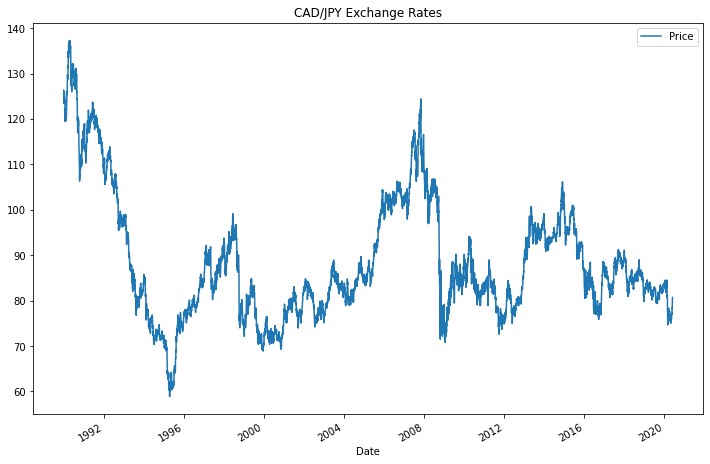

In [7]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df[["Price"]].plot(figsize=(12, 8), title="CAD/JPY Exchange Rates")

 *Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen respective to the Canadian Dollar. There do seem to be some more medium, 1-3 year consistent trends, and on a daily basis, there are a lot of short-term ups and downs. But from start-to-finish, the look is that of a downward movement in the value of the Canadian Dollar against the Yen.
 
  * By the way, why is the Canadian Dollar that's weakening, and not the Yen? After all, the price appears to be falling? This is a tricky issue of interpretation that can occur with currency pairs. The answer is that the numerator here is JPY, and the denominator 1 CAD. With that, over time, we say that 1 CAD buys continually fewer and fewer JPY. Put differently, the CAD just doesn't go as far as it used to: it takes more and more CAD to buy the same amount of Yen. We can see this visually: at the beginning of the graph, 1 CAD was able to buy around 130 Yen, but by the end, that same 1 CAD was only able to purchase about 75 Yen.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into a trend and noise.

In [8]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [9]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
futures_decomp = cad_jpy_df[["Price"]].copy()
futures_decomp["noise"] = ts_noise
futures_decomp["trend"] = ts_trend
futures_decomp.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


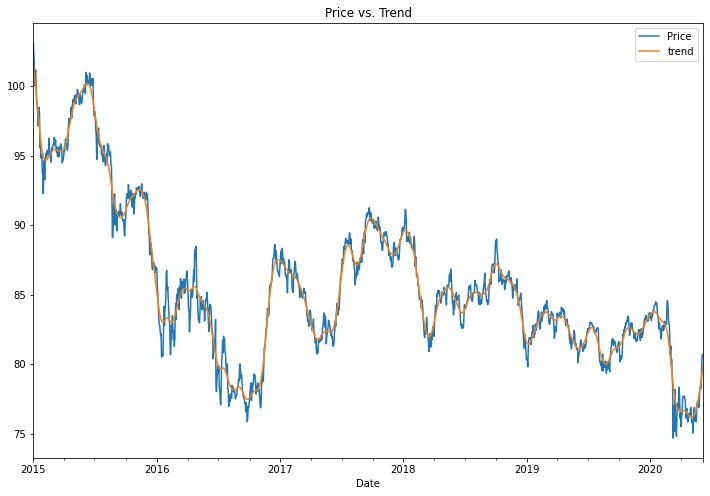

In [10]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
futures_decomp[["Price", "trend"]]["2015-01-01":].plot(figsize=(12, 8), title="Price vs. Trend")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more overvalued than it should be (and, therefore, we'd see this as a short-term selling opportunity).

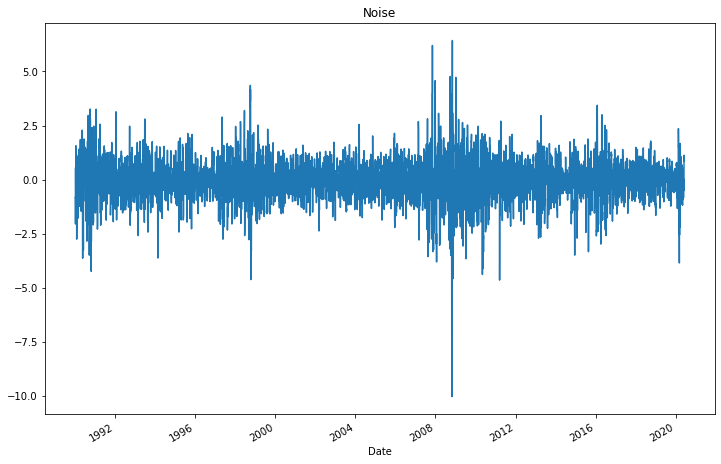

In [11]:
# Plot the Settle Noise
ts_noise.plot(figsize=(12, 8), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [13]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = sm.tsa.ARMA(returns, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 24 Aug 2020   AIC                          19513.955
Time:                        16:11:49   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Price    -0.8547      0.164     -5.201      0.000      -1.177      -0.533
ar.L2.Price    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Price     0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1702           +0.0000j           42.1702            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

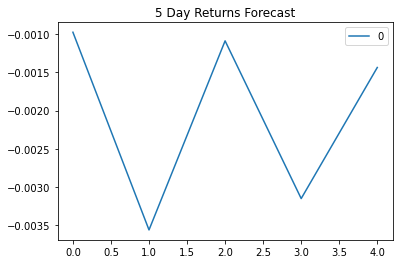

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer: Based on the model summary table, none of the p-values are below 0.05, which suggests that we may need to add additional input variables or adjust the lag order.

Assuming we were confident with this model's ability to predict, however, our model-based forecast for the next 5 days is of negative returns. Remember though, this downward negative trend means that one CAD is buying fewer and fewer Yen--the negative returns are actually a decline in value of the CAD!

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Exchange Rate Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_df[["Price"]], order=(5, 1, 1))

# Fit the model
results = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Mon, 24 Aug 2020   AIC                          17507.244
Time:                        16:11:51   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

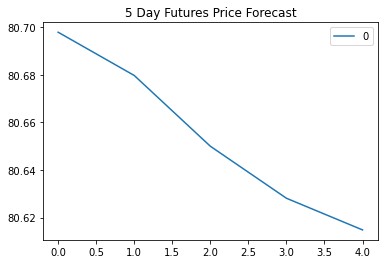

In [18]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

What does the model forecast will happen to the Japanese Yen in the near term? Based on the graph, it looks like the price of the Yen respective to the Canadian Dollar is expected to appreciate over the next five days. One CAD will be worth 80.70 tomorrow, but it'll only be worth 80.61 Yen after five days (This is consistent with the findings of our previous ARMA model, which forecasted negative returns for the CAD).

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [19]:
import arch as arch

ModuleNotFoundError: No module named 'arch'

In [ ]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit()

In [ ]:
# Summarize the model results
results.summary()

Note, our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. 

In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

Based on the graph above, the forecast for CAD/JPY volatility is that it is expected to rise over the next 5 days. 

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on our time series analysis, it **would** make sense to buy the yen now, with anticipation that it will rise further over the next five days (and that the CAD will fall in value). However, risk (up or down volatile movements) is also forecast to rise, so even if we're right, there might be some days in the interim where we see larger than usual swings in the price. 

Overall, our model for forecasting volatility looks reasonably solid. However, our models for predicting future CAD/JPY exchange rate returns (ARMA) and for CAD/JPY exchange rate prices (ARIMA) seem like they could use some improvement before we actually start using them to make financial bets. This is because none of the features included in the model (i.e., the lags) were significant, as all had p-values well above 0.05.